## Curriculum Modeling


* Define Curriculum: A dictionary (courses) maps each course to its prerequisites.
* Build Directed Graph: Nodes represent courses; directed edges represent prerequisites.
* Visualize Graph: Curriculum structure is displayed using networkx with fallback layout handling.






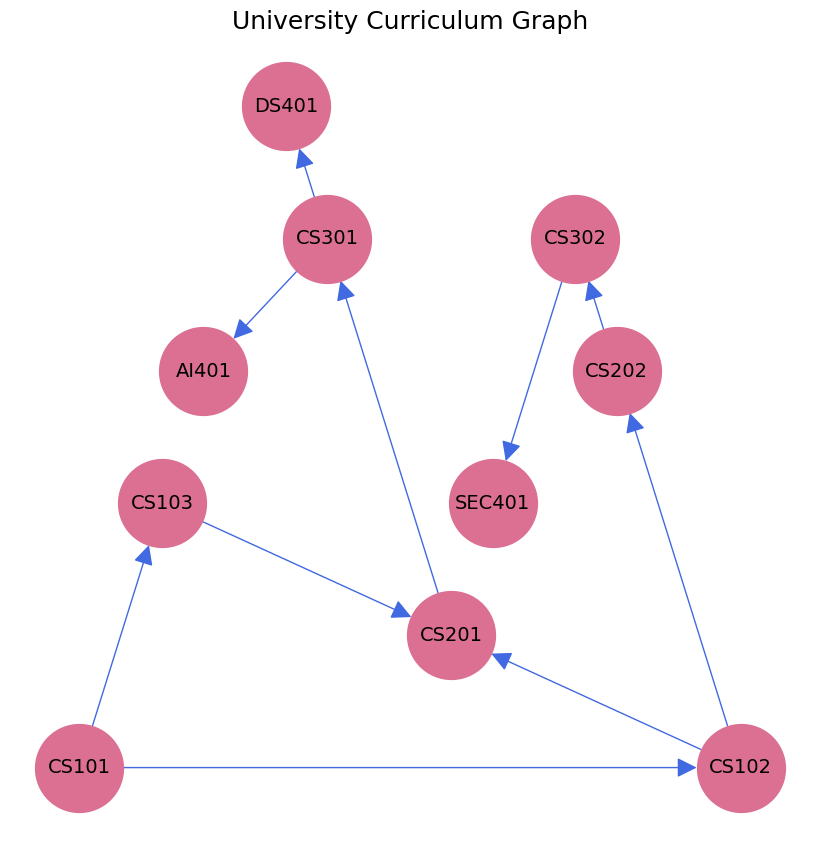

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import defaultdict


# Curriculum Graph Definition
courses = {
    "CS101": [],
    "CS102": ["CS101"],
    "CS103": ["CS101"],
    "CS201": ["CS102", "CS103"],
    "CS202": ["CS102"],
    "CS301": ["CS201"],
    "CS302": ["CS202"],
    "AI401": ["CS301"],
    "DS401": ["CS301"],
    "SEC401": ["CS302"],
}

G = nx.DiGraph()
for course, prereqs in courses.items():
    G.add_node(course)
    for prereq in prereqs:
        G.add_edge(prereq, course)

# Visualize Curriculum Graph
def plot_graph(graph):
    plt.figure(figsize=(8, 8))
    try:
        pos = nx.planar_layout(graph)
    except nx.NetworkXException:
        print("Graph is not planar, falling back to spring_layout.")
        pos = nx.spring_layout(graph, k=0.5, iterations=50)
    nx.draw(graph, pos, with_labels=True, node_color='palevioletred', node_size=4000, font_size=14, arrowsize=30, edge_color='royalblue')
    plt.title("University Curriculum Graph", fontsize=18)
    plt.show()

plot_graph(G)

# Students Simulation

In [3]:
# Simulate 100 Students
interests = ['AI', 'Data Science', 'Security']

def generate_student(student_id):
    passed_courses = random.sample(list(courses.keys()), k=random.randint(2, 6))
    gpa = round(random.uniform(2.0, 4.0), 2)
    grades = {course: round(random.uniform(60, 100), 1) for course in passed_courses}
    interest = random.choice(interests)
    return {
        "id": student_id,
        "passed_courses": passed_courses,
        "grades": grades,
        "GPA": gpa,
        "interest": interest
    }

students = [generate_student(i) for i in range(100)]



In [4]:
generate_student(20)

{'id': 20,
 'passed_courses': ['CS202', 'CS102', 'CS302', 'CS101'],
 'grades': {'CS202': 73.9, 'CS102': 84.6, 'CS302': 62.2, 'CS101': 66.9},
 'GPA': 2.92,
 'interest': 'AI'}

# Personalization Agent



* Environment Setup: AcademicAdvisorEnv simulates a student-course advising environment.

* Eligibility Checking: Determines which courses a student can take based on completed prerequisites.

* Reward Function: Gives higher rewards for selecting courses aligned with student interests and making progress.

* Simulation: Advising is simulated for 30 students with randomized course recommendations and reward calculations.



In [5]:
class AcademicAdvisorEnv:
    def __init__(self, student, course_graph):
        self.student = student
        self.graph = course_graph
        self.term = 1
        self.max_terms = 8

    def get_eligible_courses(self):
        eligible = []
        for course in self.graph.nodes:
            if course in self.student["passed_courses"]:
                continue
            prerequisites = list(self.graph.predecessors(course))
            if all(pr in self.student["passed_courses"] for pr in prerequisites):
                eligible.append(course)
        return eligible

    def reward(self, selected_courses):
        reward = 0
        for course in selected_courses:
            if self.student["interest"][:2].upper() in course:
                reward += 1  # Match interest
            reward += 0.1  # Progress bonus
        return reward

def simulate_advising(student):
    env = AcademicAdvisorEnv(student, G)
    eligible = env.get_eligible_courses()
    if not eligible:
        return {"student_id": student["id"], "recommended_courses": [], "reward": 0}
    recommended = random.sample(eligible, k=min(5, len(eligible)))
    r = env.reward(recommended)
    return {
        "student_id": student["id"],
        "interest": student["interest"],
        "recommended_courses": recommended,
        "reward": r
    }

# Run a sample for test result of the agent
sample_results = [simulate_advising(students[i]) for i in range(30)]

for res in sample_results:
    print(res)


{'student_id': 0, 'interest': 'Security', 'recommended_courses': ['CS202', 'SEC401', 'CS201'], 'reward': 1.3000000000000003}
{'student_id': 1, 'interest': 'AI', 'recommended_courses': ['CS301', 'CS202'], 'reward': 0.2}
{'student_id': 2, 'interest': 'AI', 'recommended_courses': ['CS101', 'DS401', 'CS302'], 'reward': 0.30000000000000004}
{'student_id': 3, 'interest': 'Security', 'recommended_courses': ['SEC401', 'CS301', 'CS103', 'CS102'], 'reward': 1.4000000000000004}
{'student_id': 4, 'interest': 'Data Science', 'recommended_courses': ['CS101'], 'reward': 0.1}
{'student_id': 5, 'interest': 'AI', 'recommended_courses': ['CS101'], 'reward': 0.1}
{'student_id': 6, 'interest': 'Data Science', 'recommended_courses': ['CS102', 'SEC401'], 'reward': 0.2}
{'student_id': 7, 'interest': 'AI', 'recommended_courses': ['SEC401', 'CS101', 'CS301', 'CS202'], 'reward': 0.4}
{'student_id': 8, 'interest': 'Data Science', 'recommended_courses': ['CS102', 'CS302'], 'reward': 0.2}
{'student_id': 9, 'interes

# Q-Learning Agent Implementation


* Q-Learning Agent: Implements a reinforcement learning agent to learn course recommendation strategies over time.

* State Representation: Combines course history, GPA bucket, and student interest to form a unique state.

* Action Selection: Balances exploration vs. exploitation to recommend 3 courses based on Q-values or randomly.

* Reward Function: Encourages interest alignment, GPA improvement, and curriculum progress.

* Q-Table Update: Learns from simulated student progress across multiple terms and epochs.

* Training & Testing: Trains on 10 synthetic students over 100 epochs and evaluates on 10 test students.

* Performance Plot: Visualizes reward progression to assess agent learning performance.


 -Top Recommendations for 10 Test Students- 


Test Student 20 | Interest: AI | GPA: 3.74
Passed Courses: ['SEC401', 'CS301', 'AI401', 'CS202']
Top Recommendations: ['CS101', 'CS302', 'DS401']

Test Student 21 | Interest: Security | GPA: 3.00
Passed Courses: ['CS103', 'CS101', 'CS302', 'CS201', 'CS202', 'DS401']
Top Recommendations: ['CS102', 'CS301', 'SEC401']

Test Student 22 | Interest: Data Science | GPA: 2.76
Passed Courses: ['CS101', 'CS201']
Top Recommendations: ['CS102', 'CS103', 'CS301']

Test Student 23 | Interest: Data Science | GPA: 2.54
Passed Courses: ['DS401', 'CS202', 'CS201']
Top Recommendations: ['CS101', 'CS301', 'CS302']

Test Student 24 | Interest: Security | GPA: 3.71
Passed Courses: ['CS302', 'CS301', 'DS401']
Top Recommendations: ['CS101', 'AI401', 'SEC401']

Test Student 25 | Interest: Security | GPA: 3.11
Passed Courses: ['CS102', 'CS202', 'CS201']
Top Recommendations: ['CS101', 'CS301', 'CS302']

Test Student 26 | Interest: Security | GPA: 2.84
Passed Course

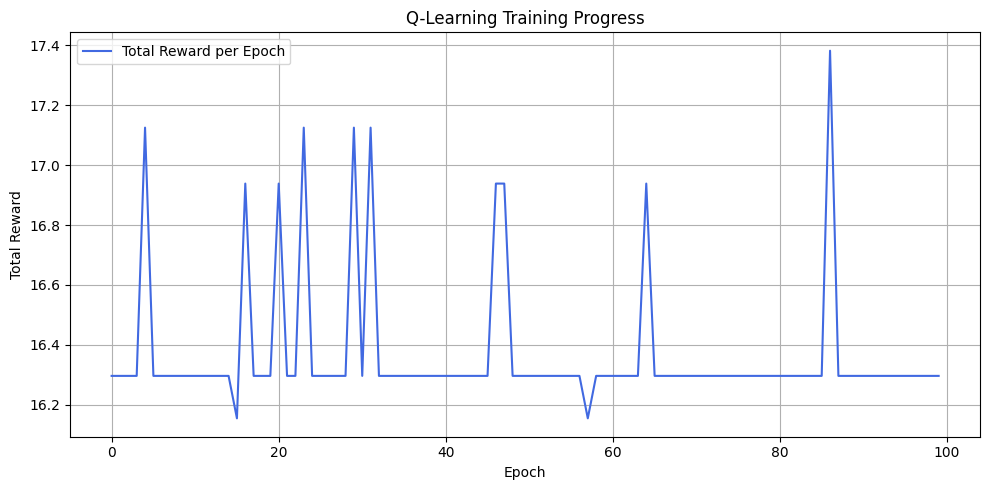

In [10]:
class QLearningAdvisor:
    def __init__(self, course_graph, interests, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.graph = course_graph
        self.interests = interests
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def get_state(self, student):
        bitstring = ''.join(['1' if c in student["passed_courses"] else '0' for c in self.graph.nodes])
        gpa_bucket = (
            'low' if student["GPA"] < 2.5 else
            'mid' if student["GPA"] < 3.5 else 'high'
        )
        return (bitstring, gpa_bucket, student["interest"])

    def get_eligible(self, student):
        eligible = []
        for course in self.graph.nodes:
            if course in student["passed_courses"]:
                continue
            prerequisites = list(self.graph.predecessors(course))
            if all(pr in student["passed_courses"] for pr in prerequisites):
                eligible.append(course)
        return eligible

    def choose_action(self, state, eligible_courses):
        if not eligible_courses:
            return []

        if random.random() < self.epsilon:
            return random.sample(eligible_courses, min(3, len(eligible_courses)))

        q_values = self.q_table[state]
        if not q_values:
            return random.sample(eligible_courses, min(3, len(eligible_courses)))

        # Rank by Q-value and select top-k
        sorted_courses = sorted(
            eligible_courses,
            key=lambda c: q_values.get(c, 0),
            reverse=True
        )
        return sorted_courses[:min(3, len(sorted_courses))]

    def get_reward(self, student, selected_courses):
        if not selected_courses:
            return 0

        reward_total = 0
        for course in selected_courses:
            interest_bonus = 1.0 if student["interest"][:2].upper() in course else 0.0
            progress_bonus = 0.1
            gpa_factor = (student["GPA"] - 2.0) / 2  # For Normalization [0,1]
            reward_total += interest_bonus + progress_bonus + gpa_factor
        return reward_total / len(selected_courses)

    def update_q(self, state, action, reward, next_state):
        max_next_q = max(self.q_table[next_state].values(), default=0)
        self.q_table[state][action] += self.alpha * (
            reward + self.gamma * max_next_q - self.q_table[state][action]
        )


random.seed(42)
np.random.seed(42)

# Reset the Student Data
def clone_student(original):
    return {
        "id": original["id"],
        "passed_courses": original["passed_courses"][:],
        "grades": original["grades"].copy(),
        "GPA": original["GPA"],
        "interest": original["interest"]
    }

# Initialize agent
agent = QLearningAdvisor(G, interests)

# Track reward per epoch
epoch_rewards = []

# Fixed student set
train_students = [generate_student(i) for i in range(10)]

# Training
for epoch in range(100):
    total_reward = 0

    for orig in train_students:
        student = clone_student(orig)

        for term in range(4):
            state = agent.get_state(student)
            eligible = agent.get_eligible(student)
            if not eligible:
                break

            selected_courses = agent.choose_action(state, eligible)
            if not selected_courses:
                break

            reward = agent.get_reward(student, selected_courses)

            for course in selected_courses:
                student["passed_courses"].append(course)

            # GPA adjustment based on reward quality ( GPA Maximization and Minimization )
            if reward > 1.0:
                student["GPA"] = min(4.0, student["GPA"] + 0.05)
            elif reward < 0.5:
                student["GPA"] = max(2.0, student["GPA"] - 0.05)

            next_state = agent.get_state(student)

            for course in selected_courses:
                agent.update_q(state, course, reward, next_state)

            total_reward += reward

    agent.epsilon = max(0.01, agent.epsilon * 0.99)
    epoch_rewards.append(total_reward)

print("\n -Top Recommendations for 10 Test Students- \n")

for sid in range(20, 30):  # Generate 10 students with IDs 20 to 29
    test_student = generate_student(sid)
    print(f"\nTest Student {test_student['id']} | Interest: {test_student['interest']} | GPA: {test_student['GPA']:.2f}")
    print(f"Passed Courses: {test_student['passed_courses']}")

    state = agent.get_state(test_student)
    eligible = agent.get_eligible(test_student)

    if eligible:
        eligible_q_values = {
            course: agent.q_table[state].get(course, 0) for course in eligible
        }
        recommendations = sorted(
            eligible_q_values, key=eligible_q_values.get, reverse=True
        )[:5]
        print(f"Top Recommendations: {recommendations}")
    else:
        print("No eligible courses to recommend.")


# Plot performance
plt.figure(figsize=(10, 5))
plt.plot(epoch_rewards, label='Total Reward per Epoch', color='royalblue')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.title('Q-Learning Training Progress')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
